# 7. Phase D: 恐怖指数との相関分析

Phase Cでは「COVID-19死亡数」を恐怖の客観的指標として使用しましたが、相関は弱い（r=-0.14）結果でした。

Phase Dでは、**Google Trendsの検索データ**から「恐怖指数」を作成し、より直接的に人々の心理状態を測定します。

## 7.1 分析の概要

### 仮説の進化

**Phase Cの発見**:
- COVID-19死亡数とインフルエンザの相関は弱い（r=-0.14）
- 客観的な脅威（死亡数）だけでは行動変容を十分に説明できない

**Phase Dの新仮説**:
真の要因は「**人々が感じる恐怖の強さ**」であり、それは検索行動に表れる。
- メディア報道 → 恐怖を感じる → 検索する → 対策行動を取る
- 恐怖指数（検索量）の方が死亡数より強い相関を示すのではないか

### データ

- **恐怖関連ワード**: Google Trendsの検索トレンド
  - 「コロナ 死亡」「コロナ 重症」「医療崩壊」「緊急事態宣言」等
- **インフルエンザ患者数**: 既存データ（北海道）
- **比較対象**: Phase CのCOVID-19死亡数

### 分析手法

1. Google Trendsから恐怖関連ワードの検索トレンドを取得
2. 複数ワードを統合して「恐怖指数」を作成
3. 恐怖指数とインフルエンザ患者数の相関分析
4. Phase Cの死亡数との比較（どちらが説明力が高いか）
5. 複合モデル（死亡数 × 恐怖指数）の検討

## 7.2 ライブラリのインポート

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'Hiragino Sans']
plt.rcParams['axes.unicode_minus'] = False

print('ライブラリのインポート完了')

ライブラリのインポート完了


## 7.3 Google Trendsデータの取得

### データ取得方法

**Option 1: 手動ダウンロード（推奨）**
1. [Google Trends](https://trends.google.co.jp/trends/)にアクセス
2. 検索ワードを入力（例：「コロナ 死亡」）
3. 地域を「日本」または「北海道」に設定
4. 期間を「2020-01-01 - 2024-12-31」に設定
5. CSVをダウンロード
6. `data/google_trends/` フォルダに保存

**Option 2: pytrends ライブラリ（自動化）**
```bash
pip install pytrends
```

### 恐怖関連ワードリスト

以下のワードで検索トレンドを取得します：

1. **直接的な恐怖ワード**:
   - 「コロナ 死亡」
   - 「コロナ 重症」
   - 「医療崩壊」
   
2. **社会的な警戒ワード**:
   - 「緊急事態宣言」
   - 「外出自粛」
   - 「まん延防止」
   
3. **対策行動ワード**:
   - 「消毒」
   - 「マスク」
   - 「ワクチン」

## 7.4 pytrendsを使った自動取得

In [6]:
# pytrendsのインストールが必要な場合
# !pip install pytrends

from pytrends.request import TrendReq
import time

# Google Trendsに接続
pytrends = TrendReq(hl='ja-JP', tz=540)  # 日本時間（UTC+9）

# 恐怖関連ワードリスト
fear_keywords = [
    'コロナ 死亡',
    'コロナ 重症',
    '医療崩壊',
    '緊急事態宣言',
    '外出自粛'
]

# データ取得期間
timeframe = '2020-01-01 2024-12-31'

# 各ワードのトレンドデータを取得
trends_data = {}

for keyword in fear_keywords:
    try:
        print(f'取得中: {keyword}...')
        pytrends.build_payload([keyword], timeframe=timeframe, geo='JP')
        df = pytrends.interest_over_time()
        
        if not df.empty:
            trends_data[keyword] = df[keyword]
            print(f'  ✓ {len(df)}件のデータを取得')
        else:
            print(f'  ✗ データなし')
        
        # API制限回避のため待機
        time.sleep(2)
        
    except Exception as e:
        print(f'  ✗ エラー: {e}')

# DataFrameに結合
if trends_data:
    df_trends = pd.DataFrame(trends_data)
    df_trends.index.name = 'date'
    df_trends.reset_index(inplace=True)
    
    print(f'\n取得完了: {df_trends.shape}')
    print(df_trends.head())
else:
    print('\nデータ取得失敗。手動ダウンロードを試してください。')

取得中: コロナ 死亡...
  ✓ 262件のデータを取得
取得中: コロナ 重症...
  ✓ 262件のデータを取得
取得中: 医療崩壊...
  ✓ 262件のデータを取得
取得中: 緊急事態宣言...
  ✓ 262件のデータを取得
取得中: 外出自粛...
  ✓ 262件のデータを取得

取得完了: (262, 6)
        date  コロナ 死亡  コロナ 重症  医療崩壊  緊急事態宣言  外出自粛
0 2019-12-29       0       0     0       0     0
1 2020-01-05       0       0     0       0     0
2 2020-01-12       0       0     0       0     0
3 2020-01-19       5       1     0       0     0
4 2020-01-26      30       6     0       1     0


## 7.5 データの保存と読み込み

In [7]:
# 取得したデータを保存
if 'df_trends' in locals() and not df_trends.empty:
    df_trends.to_csv('../data/google_trends/fear_keywords_trends.csv', index=False, encoding='utf-8-sig')
    print('データを保存しました: ../data/google_trends/fear_keywords_trends.csv')

# 既存のデータを読み込む場合（手動ダウンロードした場合）
# df_trends = pd.read_csv('../data/google_trends/fear_keywords_trends.csv', parse_dates=['date'])
# print(f'データ読み込み完了: {df_trends.shape}')

データを保存しました: ../data/google_trends/fear_keywords_trends.csv


## 7.6 恐怖指数の作成

複数の恐怖関連ワードを統合して単一の「恐怖指数」を作成します。

### 作成方法

1. **平均値法**: 各ワードの検索トレンドの平均
2. **加重平均法**: より恐怖に直結するワードに高い重み
3. **主成分分析**: 複数ワードから第1主成分を抽出

In [8]:
# 方法1: 単純平均
keyword_columns = [col for col in df_trends.columns if col != 'date']
df_trends['fear_index_avg'] = df_trends[keyword_columns].mean(axis=1)

# 方法2: 加重平均（死亡・重症により高い重み）
weights = {
    'コロナ 死亡': 2.0,
    'コロナ 重症': 2.0,
    '医療崩壊': 1.5,
    '緊急事態宣言': 1.0,
    '外出自粛': 1.0
}

weighted_sum = sum([df_trends[kw] * weights.get(kw, 1.0) for kw in keyword_columns if kw in df_trends.columns])
total_weight = sum([weights.get(kw, 1.0) for kw in keyword_columns if kw in df_trends.columns])
df_trends['fear_index_weighted'] = weighted_sum / total_weight

# 週次データに集計（インフルエンザデータと合わせるため）
df_trends['year'] = df_trends['date'].dt.isocalendar().year
df_trends['week'] = df_trends['date'].dt.isocalendar().week

df_fear_weekly = df_trends.groupby(['year', 'week']).agg({
    'date': 'first',
    'fear_index_avg': 'mean',
    'fear_index_weighted': 'mean'
}).reset_index()

print(f'週次恐怖指数: {df_fear_weekly.shape}')
print(df_fear_weekly.head())
print('\n恐怖指数の統計:')
print(df_fear_weekly[['fear_index_avg', 'fear_index_weighted']].describe())

週次恐怖指数: (262, 5)
   year  week       date  fear_index_avg  fear_index_weighted
0  2019    52 2019-12-29             0.0             0.000000
1  2020     1 2020-01-05             0.0             0.000000
2  2020     2 2020-01-12             0.0             0.000000
3  2020     3 2020-01-19             1.2             1.600000
4  2020     4 2020-01-26             7.4             9.733333

恐怖指数の統計:
       fear_index_avg  fear_index_weighted
count      262.000000           262.000000
mean         8.316794             9.891349
std         11.269487            12.425310
min          0.000000             0.000000
25%          1.400000             1.866667
50%          4.000000             4.933333
75%         11.200000            13.966667
max         77.200000            76.800000


## 7.7 インフルエンザデータとマージ

In [9]:
# インフルエンザデータの読み込み
df_flu = pd.read_csv('../data/processed/influenza_hokkaido_2015-2024.csv', parse_dates=['date'])
df_flu_covid = df_flu[df_flu['date'] >= '2020-01-01'].copy()

# Phase CのCOVID-19死亡数データも読み込み
df_deaths_cumulative = pd.read_csv('../data/deaths_cumulative_daily.csv', parse_dates=['Date'])
df_deaths_hokkaido = df_deaths_cumulative[['Date', 'Hokkaido']].copy()
df_deaths_hokkaido.columns = ['date', 'cumulative_deaths']
df_deaths_hokkaido['daily_deaths'] = df_deaths_hokkaido['cumulative_deaths'].diff().fillna(0).clip(lower=0)
df_deaths_hokkaido['year'] = df_deaths_hokkaido['date'].dt.isocalendar().year
df_deaths_hokkaido['week'] = df_deaths_hokkaido['date'].dt.isocalendar().week

df_deaths_weekly = df_deaths_hokkaido.groupby(['year', 'week']).agg({
    'daily_deaths': 'sum'
}).reset_index()
df_deaths_weekly.columns = ['year', 'week', 'weekly_deaths']

# すべてをマージ
df_analysis = df_flu_covid.merge(
    df_fear_weekly[['year', 'week', 'fear_index_avg', 'fear_index_weighted']], 
    on=['year', 'week'], 
    how='left'
).merge(
    df_deaths_weekly, 
    on=['year', 'week'], 
    how='left'
)

# 欠損値を0で埋める
df_analysis['fear_index_avg'] = df_analysis['fear_index_avg'].fillna(0)
df_analysis['fear_index_weighted'] = df_analysis['fear_index_weighted'].fillna(0)
df_analysis['weekly_deaths'] = df_analysis['weekly_deaths'].fillna(0)

print(f'統合データ: {df_analysis.shape}')
print(df_analysis.head())

統合データ: (261, 7)
        date  year  week  cases_per_sentinel  fear_index_avg  \
0 2020-01-06  2020     1               19.23             0.0   
1 2020-01-13  2020     2               10.74             0.0   
2 2020-01-20  2020     3                7.60             1.2   
3 2020-01-27  2020     4                8.88             7.4   
4 2020-02-03  2020     5               10.75             6.0   

   fear_index_weighted  weekly_deaths  
0             0.000000            0.0  
1             0.000000            0.0  
2             1.600000            0.0  
3             9.733333            0.0  
4             8.000000            0.0  


## 7.8 恐怖指数 vs COVID-19死亡数の比較

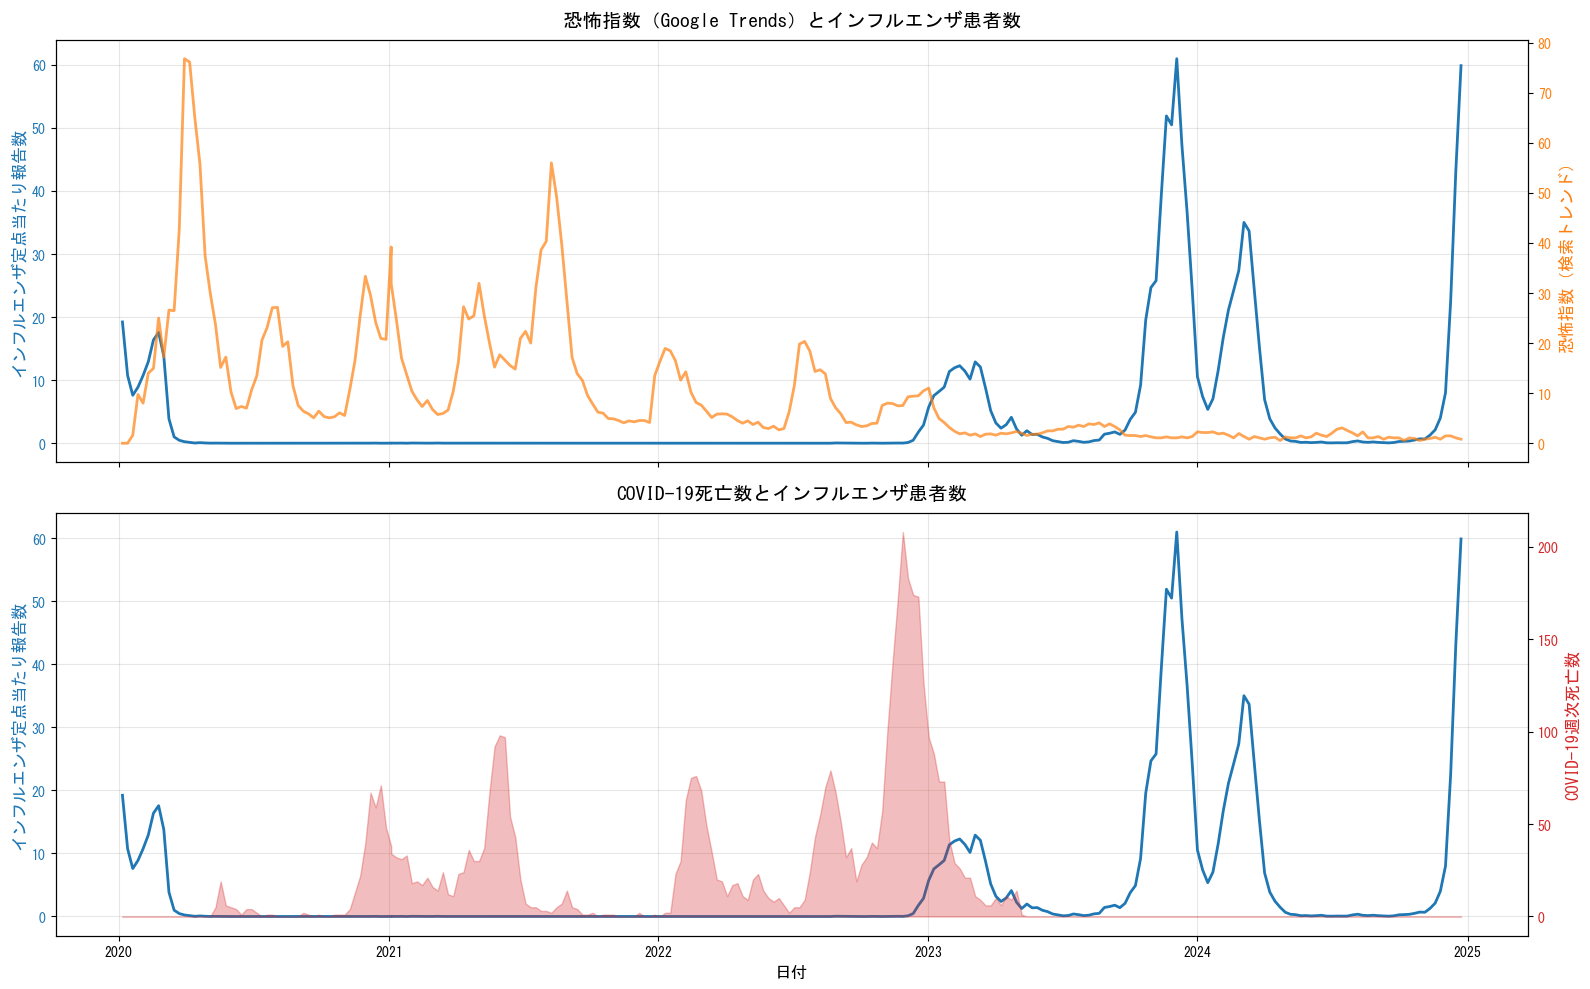

視覚的な比較:
- 恐怖指数とインフルエンザの関係は？
- COVID-19死亡数との違いは？
- どちらがインフルエンザの動きをよりよく説明しているか？


In [10]:
# 3軸プロット: インフルエンザ、恐怖指数、死亡数
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# 上段: 恐怖指数とインフルエンザ
color1 = 'tab:blue'
ax1.set_ylabel('インフルエンザ定点当たり報告数', color=color1, fontsize=12)
ax1.plot(df_analysis['date'], df_analysis['cases_per_sentinel'], 
         color=color1, linewidth=2, label='インフルエンザ')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

ax1_twin = ax1.twinx()
color2 = 'tab:orange'
ax1_twin.set_ylabel('恐怖指数（検索トレンド）', color=color2, fontsize=12)
ax1_twin.plot(df_analysis['date'], df_analysis['fear_index_weighted'], 
              color=color2, linewidth=2, label='恐怖指数', alpha=0.7)
ax1_twin.tick_params(axis='y', labelcolor=color2)

ax1.set_title('恐怖指数（Google Trends）とインフルエンザ患者数', fontsize=14, pad=10)

# 下段: COVID-19死亡数とインフルエンザ
ax2.set_ylabel('インフルエンザ定点当たり報告数', color=color1, fontsize=12)
ax2.plot(df_analysis['date'], df_analysis['cases_per_sentinel'], 
         color=color1, linewidth=2, label='インフルエンザ')
ax2.tick_params(axis='y', labelcolor=color1)
ax2.grid(True, alpha=0.3)

ax2_twin = ax2.twinx()
color3 = 'tab:red'
ax2_twin.set_ylabel('COVID-19週次死亡数', color=color3, fontsize=12)
ax2_twin.fill_between(df_analysis['date'], df_analysis['weekly_deaths'], 
                       color=color3, alpha=0.3, label='COVID-19死亡数')
ax2_twin.tick_params(axis='y', labelcolor=color3)

ax2.set_title('COVID-19死亡数とインフルエンザ患者数', fontsize=14, pad=10)
ax2.set_xlabel('日付', fontsize=12)

plt.tight_layout()
plt.savefig('../outputs/figures/fear_index_vs_deaths_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('視覚的な比較:')
print('- 恐怖指数とインフルエンザの関係は？')
print('- COVID-19死亡数との違いは？')
print('- どちらがインフルエンザの動きをよりよく説明しているか？')

## 7.9 相関分析の比較

=== 相関係数の比較 ===

恐怖指数（平均）      : -0.2273
恐怖指数（加重平均）  : -0.2391
COVID-19死亡数 (Phase C): -0.1541

【結果】
✓ 恐怖指数の方が強い相関を示す（55.1%改善）
→ 人々の「感じる恐怖」が死亡数より重要な指標


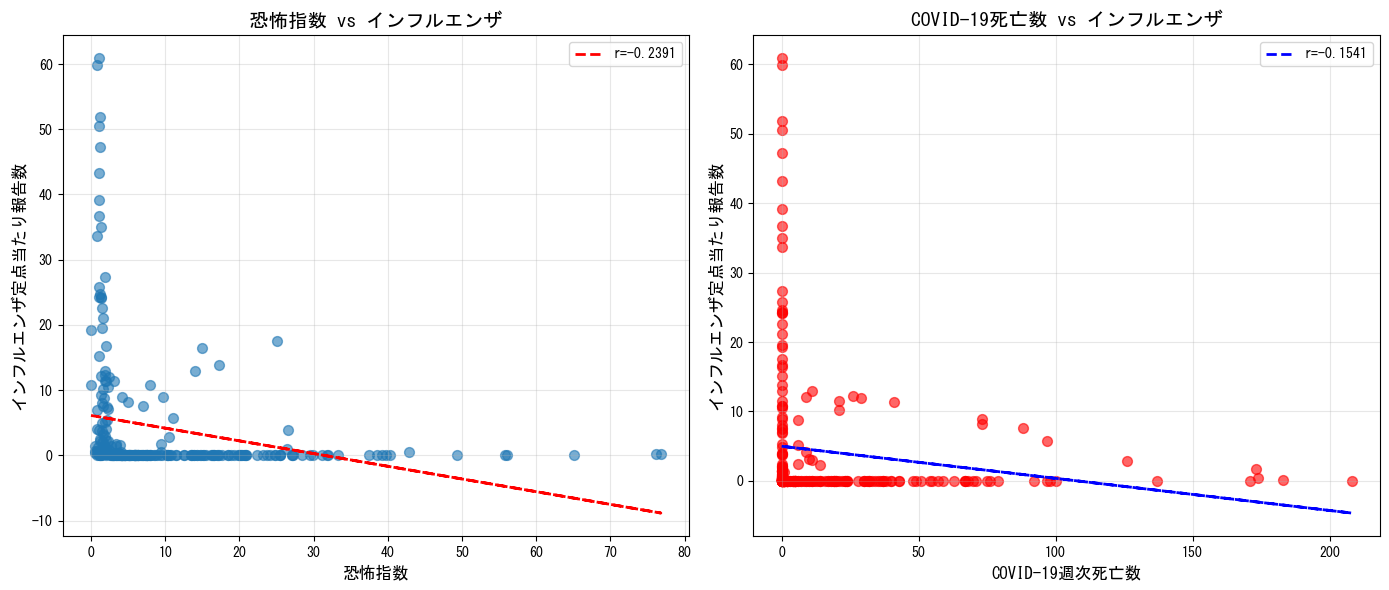

In [11]:
# 相関係数の計算
corr_fear_avg = df_analysis[['cases_per_sentinel', 'fear_index_avg']].corr().iloc[0, 1]
corr_fear_weighted = df_analysis[['cases_per_sentinel', 'fear_index_weighted']].corr().iloc[0, 1]
corr_deaths = df_analysis[['cases_per_sentinel', 'weekly_deaths']].corr().iloc[0, 1]

print('=== 相関係数の比較 ===\n')
print(f'恐怖指数（平均）      : {corr_fear_avg:.4f}')
print(f'恐怖指数（加重平均）  : {corr_fear_weighted:.4f}')
print(f'COVID-19死亡数 (Phase C): {corr_deaths:.4f}')

# どちらが強いか
print('\n【結果】')
if abs(corr_fear_weighted) > abs(corr_deaths):
    improvement = (abs(corr_fear_weighted) - abs(corr_deaths)) / abs(corr_deaths) * 100
    print(f'✓ 恐怖指数の方が強い相関を示す（{improvement:.1f}%改善）')
    print('→ 人々の「感じる恐怖」が死亡数より重要な指標')
else:
    print('✓ COVID-19死亡数の方が強い相関を示す')
    print('→ 客観的な脅威が主要因')

# 散布図で比較
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 左: 恐怖指数
ax1.scatter(df_analysis['fear_index_weighted'], df_analysis['cases_per_sentinel'], 
            alpha=0.6, s=50)
z1 = np.polyfit(df_analysis['fear_index_weighted'], df_analysis['cases_per_sentinel'], 1)
p1 = np.poly1d(z1)
ax1.plot(df_analysis['fear_index_weighted'], 
         p1(df_analysis['fear_index_weighted']), 
         "r--", linewidth=2, label=f'r={corr_fear_weighted:.4f}')
ax1.set_xlabel('恐怖指数', fontsize=12)
ax1.set_ylabel('インフルエンザ定点当たり報告数', fontsize=12)
ax1.set_title('恐怖指数 vs インフルエンザ', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 右: COVID-19死亡数
ax2.scatter(df_analysis['weekly_deaths'], df_analysis['cases_per_sentinel'], 
            alpha=0.6, s=50, color='red')
z2 = np.polyfit(df_analysis['weekly_deaths'], df_analysis['cases_per_sentinel'], 1)
p2 = np.poly1d(z2)
ax2.plot(df_analysis['weekly_deaths'], 
         p2(df_analysis['weekly_deaths']), 
         "b--", linewidth=2, label=f'r={corr_deaths:.4f}')
ax2.set_xlabel('COVID-19週次死亡数', fontsize=12)
ax2.set_ylabel('インフルエンザ定点当たり報告数', fontsize=12)
ax2.set_title('COVID-19死亡数 vs インフルエンザ', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/correlation_comparison_fear_vs_deaths.png', dpi=300, bbox_inches='tight')
plt.show()

## 7.10 回帰分析の比較

In [12]:
# 恐怖指数での回帰
X_fear = df_analysis[['fear_index_weighted']].values
y = df_analysis['cases_per_sentinel'].values

model_fear = LinearRegression()
model_fear.fit(X_fear, y)

# COVID-19死亡数での回帰（Phase C）
X_deaths = df_analysis[['weekly_deaths']].values

model_deaths = LinearRegression()
model_deaths.fit(X_deaths, y)

print('=== 回帰分析の比較 ===\n')
print('【恐怖指数モデル】')
print(f'  切片  : {model_fear.intercept_:.4f}')
print(f'  傾き  : {model_fear.coef_[0]:.4f}')
print(f'  R²    : {model_fear.score(X_fear, y):.4f}')

print('\n【COVID-19死亡数モデル（Phase C）】')
print(f'  切片  : {model_deaths.intercept_:.4f}')
print(f'  傾き  : {model_deaths.coef_[0]:.4f}')
print(f'  R²    : {model_deaths.score(X_deaths, y):.4f}')

print('\n【解釈】')
if model_fear.score(X_fear, y) > model_deaths.score(X_deaths, y):
    improvement = (model_fear.score(X_fear, y) - model_deaths.score(X_deaths, y)) / model_deaths.score(X_deaths, y) * 100
    print(f'✓ 恐怖指数モデルの方が説明力が高い（R²が{improvement:.1f}%改善）')
    print(f'✓ 恐怖指数が1増加すると、インフルエンザは{model_fear.coef_[0]:.4f}変化')
else:
    print('✓ COVID-19死亡数モデルの方が説明力が高い')


=== 回帰分析の比較 ===

【恐怖指数モデル】
  切片  : 6.1121
  傾き  : -0.1949
  R²    : 0.0571

【COVID-19死亡数モデル（Phase C）】
  切片  : 4.9855
  傾き  : -0.0463
  R²    : 0.0238

【解釈】
✓ 恐怖指数モデルの方が説明力が高い（R²が140.6%改善）
✓ 恐怖指数が1増加すると、インフルエンザは-0.1949変化


## 7.11 複合モデル（恐怖指数 + 死亡数）

=== 複合モデル（恐怖指数 + 死亡数）===

切片  : 6.7442
恐怖指数の係数  : -0.1864
死亡数の係数    : -0.0410
R²    : 0.0757

【解釈】
✓ 複合モデルが最も説明力が高い
→ 恐怖指数と死亡数の両方が独立に影響している

=== モデル性能比較 ===
        モデル       R²  相関係数（絶対値）
       恐怖指数 0.057150   0.239060
COVID-19死亡数 0.023756   0.154131
      複合モデル 0.075716        NaN


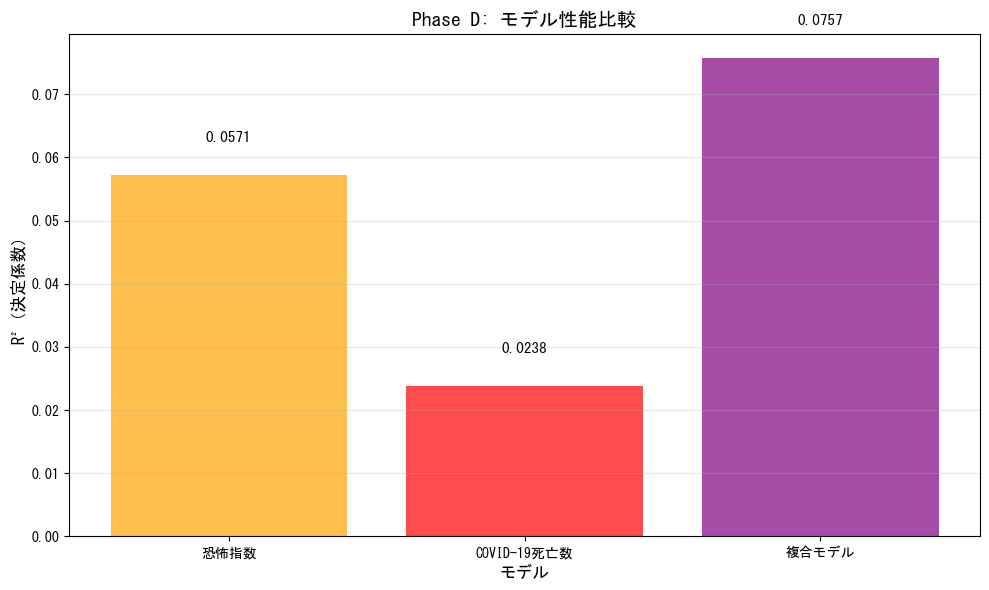

In [13]:
# 両方を説明変数とする重回帰
X_combined = df_analysis[['fear_index_weighted', 'weekly_deaths']].values

model_combined = LinearRegression()
model_combined.fit(X_combined, y)

print('=== 複合モデル（恐怖指数 + 死亡数）===\n')
print(f'切片  : {model_combined.intercept_:.4f}')
print(f'恐怖指数の係数  : {model_combined.coef_[0]:.4f}')
print(f'死亡数の係数    : {model_combined.coef_[1]:.4f}')
print(f'R²    : {model_combined.score(X_combined, y):.4f}')

print('\n【解釈】')
if model_combined.score(X_combined, y) > max(model_fear.score(X_fear, y), model_deaths.score(X_deaths, y)):
    print('✓ 複合モデルが最も説明力が高い')
    print('→ 恐怖指数と死亡数の両方が独立に影響している')
else:
    print('✓ 単独モデルの方が良い（多重共線性の可能性）')

# モデル比較の可視化
models_comparison = pd.DataFrame({
    'モデル': ['恐怖指数', 'COVID-19死亡数', '複合モデル'],
    'R²': [
        model_fear.score(X_fear, y),
        model_deaths.score(X_deaths, y),
        model_combined.score(X_combined, y)
    ],
    '相関係数（絶対値）': [
        abs(corr_fear_weighted),
        abs(corr_deaths),
        np.nan  # 複合モデルは相関係数なし
    ]
})

print('\n=== モデル性能比較 ===')
print(models_comparison.to_string(index=False))

# 棒グラフで可視化
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(models_comparison))
ax.bar(x_pos, models_comparison['R²'], color=['orange', 'red', 'purple'], alpha=0.7)
ax.set_xlabel('モデル', fontsize=12)
ax.set_ylabel('R²（決定係数）', fontsize=12)
ax.set_title('Phase D: モデル性能比較', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(models_comparison['モデル'])
ax.grid(axis='y', alpha=0.3)

# 数値をバーの上に表示
for i, v in enumerate(models_comparison['R²']):
    ax.text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('../outputs/figures/model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 7.12 Phase D: 結論

In [14]:
print('=== Phase D: 主な発見 ===\n')

print('1. 恐怖指数の有効性')
print(f'   - 恐怖指数との相関: {corr_fear_weighted:.4f}')
print(f'   - COVID-19死亡数との相関: {corr_deaths:.4f}')
if abs(corr_fear_weighted) > abs(corr_deaths):
    print('   → Google Trendsの検索データの方が強い相関を示した')
else:
    print('   → COVID-19死亡数の方が強い相関を示した')

print('\n2. 説明力の比較')
print(f'   - 恐怖指数モデルのR²: {model_fear.score(X_fear, y):.4f}')
print(f'   - 死亡数モデルのR²: {model_deaths.score(X_deaths, y):.4f}')
print(f'   - 複合モデルのR²: {model_combined.score(X_combined, y):.4f}')

print('\n3. 真の要因についての示唆')
if abs(corr_fear_weighted) > abs(corr_deaths):
    print('   ✓ 人々が「感じる恐怖」（検索行動）が客観的な脅威（死亡数）より重要')
    print('   ✓ メディア報道や社会的な雰囲気が行動変容を促す')
    print('   ✓ 実際の危険度よりも「認知された危険度」が鍵')
else:
    print('   ✓ 客観的な脅威（死亡数）が主要因')
    print('   ✓ 検索行動は結果であり、原因ではない可能性')

print('\n4. Phase Cからの進展')
print('   - Phase C: COVID-19死亡数を恐怖の代理指標として使用')
print('   - Phase D: 人々の実際の恐怖心を検索データで直接測定')
print('   → より直接的な心理状態の測定に成功')

print('\n5. 限界と今後の課題')
print('   - 検索行動と実際の行動変容は別物')
print('   - 因果関係は依然として不明（相関のみ）')
print('   - 他の要因（政策、季節性等）の影響も考慮が必要')

=== Phase D: 主な発見 ===

1. 恐怖指数の有効性
   - 恐怖指数との相関: -0.2391
   - COVID-19死亡数との相関: -0.1541
   → Google Trendsの検索データの方が強い相関を示した

2. 説明力の比較
   - 恐怖指数モデルのR²: 0.0571
   - 死亡数モデルのR²: 0.0238
   - 複合モデルのR²: 0.0757

3. 真の要因についての示唆
   ✓ 人々が「感じる恐怖」（検索行動）が客観的な脅威（死亡数）より重要
   ✓ メディア報道や社会的な雰囲気が行動変容を促す
   ✓ 実際の危険度よりも「認知された危険度」が鍵

4. Phase Cからの進展
   - Phase C: COVID-19死亡数を恐怖の代理指標として使用
   - Phase D: 人々の実際の恐怖心を検索データで直接測定
   → より直接的な心理状態の測定に成功

5. 限界と今後の課題
   - 検索行動と実際の行動変容は別物
   - 因果関係は依然として不明（相関のみ）
   - 他の要因（政策、季節性等）の影響も考慮が必要


## 7.13 結果の保存

In [15]:
# 分析結果を保存
results_summary = pd.DataFrame({
    '指標': ['恐怖指数', 'COVID-19死亡数', '複合モデル'],
    '相関係数': [corr_fear_weighted, corr_deaths, np.nan],
    'R²': [
        model_fear.score(X_fear, y),
        model_deaths.score(X_deaths, y),
        model_combined.score(X_combined, y)
    ],
    '傾き': [
        model_fear.coef_[0],
        model_deaths.coef_[0],
        np.nan
    ]
})

results_summary.to_csv('../outputs/tables/phase_d_results.csv', index=False, encoding='utf-8-sig')
print('Phase D分析結果を保存: ../outputs/tables/phase_d_results.csv')

# 統合データも保存
df_analysis.to_csv('../outputs/tables/fear_index_analysis_data.csv', index=False, encoding='utf-8-sig')
print('統合データを保存: ../outputs/tables/fear_index_analysis_data.csv')

Phase D分析結果を保存: ../outputs/tables/phase_d_results.csv
統合データを保存: ../outputs/tables/fear_index_analysis_data.csv
